# Large Language Models

A language model is a machine learning model that aims to predict and generate plausible language. Autocomplete is a language model, for example.

These models work by estimating the probability of a token or sequence of tokens occurring within a longer sequence of tokens. Consider the following sentence:



```
When I hear rain on my roof, I _______ in my kitchen.
```

If you assume that a token is a word, then a language model determines the probabilities of different words or sequences of words to replace that underscore. For example, a language model might determine the following probabilities:



```
cook soup 9.4%
warm up a kettle 5.2%
cower 3.6%
nap 2.5%
relax 2.2%
```





## Environmet Setup

In order to execute our model properly, we will install Transformers from source. This way, we can ensure the most recent features.

In [ ]:
!pip install transformers bitsandbytes peft
!pip install -U datasets

## Importing Dependencies

In our experiments, we will use Phi 1.5. This model was trained by Microsoft with the aim of having a large language model (relatively) small. Ususally LLMs range between 7 billion parameters, up to 70 or even 175B. Our model consists of 1.5 billion, which is already a challenge for Google Colab.

In [ ]:
#importing library
from huggingface_hub import notebook_login
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig, TextStreamer
from peft import LoraConfig, get_peft_model, PeftModel
import torch, os, wandb
#wandb.login(key = "wandb authorization key")
new_model = "phi_aidl"
base_model = "microsoft/phi-1_5"

In [ ]:
from IPython.display import display, Markdown, update_display
import uuid

In [ ]:
class MarkdownStreamer(TextStreamer):
    """
    A custom TextStreamer that formats the output as Markdown in a Colab notebook.
    It accumulates the streamed text and updates a single display cell.
    """
    def __init__(self, tokenizer: AutoTokenizer, **kwargs):
        super().__init__(tokenizer, **kwargs)
        self.full_text = ""
        # Create a unique ID for the display area
        self.display_id = str(uuid.uuid4())
        # Create the initial empty display area
        display(Markdown(""), display_id=self.display_id)

    def on_finalized_text(self, text: str, stream_end: bool = False):
        """
        Appends the new text to the full text and updates the display.
        """
        # Append the new text chunk and add a blinking cursor for effect
        self.full_text += text
        display_text = self.full_text
        if not stream_end:
            display_text += "▌" # Use a block character as a cursor

        # Update the display with the new Markdown content
        update_display(Markdown(display_text), display_id=self.display_id)

The first thing we have to do is download our model and prepare all the necessary code to ask questions. To ensure that our model fits in Colab, we will use **4 bit Quantization**. Usually, weights use the datatype float 32. This means that 32 bits (or 4 bytes) are needed to store each one of them. And there are 1.5 billion of them in our model. 4 bit quantization allows to represent them using only 4 bits ( half a byte), reducing 8 times the size of the model stored in memory.

In [ ]:
#loading the model and tokenizer
bitsandbytes= BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model, device_map={"":0},
    quantization_config= bitsandbytes, trust_remote_code= True
)
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
# Testing the trained model
def phi_stream(prompt):
  runtimeFlag = "cuda:0"
  inputs = tokenizer(f'''Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{prompt}.\n\n### Response:\n ''', return_tensors="pt", return_attention_mask=False).to(runtimeFlag)
  streamer = MarkdownStreamer(tokenizer, skip_prompt= True)
  _ = model.generate(**inputs, streamer=streamer, max_new_tokens=300)



**Exercise 1:** Using the function above, ask the model what is a langguage model. How is the answer you are getting?

In [ ]:
# TODO


**Exercise 2:** Try other prompts on the model. Are you able to obtain good answers?

In [ ]:
# TODO


## Instruction Tuning

Base language models may have learned how to complete a given text, but they still have problems  following instructions.
To improve their performace, we will apply **Instruction Tuning.** This step consists on finetuning our model on a dataset that includes instructions for a variaty of classes and their expected responses from the model.  Unlike previous finetunig approaches, the aim is not to improve the model in a specific task. We want to train the model on follow instructions and perform a new task just from the information on the prompt. This allows to perform several tasks without requiring any further training.


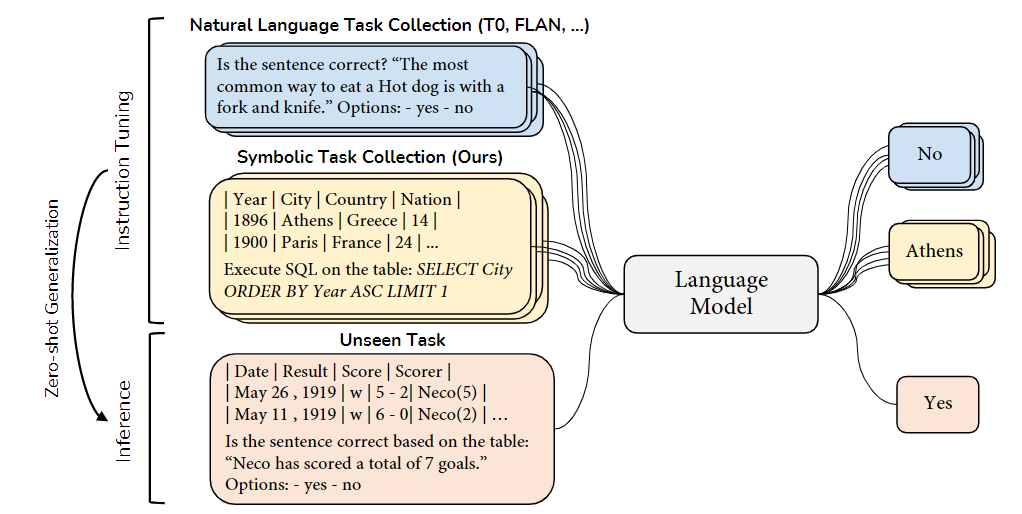



First of all, we will download an instruction dataset. For our experiment, we will use alpaca-gpt4. This dataset includes 52.000 instructions and their respective answer generated by gpt4. To speed up the training we will use only 1% of the total dataset.

In [ ]:
#Tokenzing the dataset
def tok(sample):
    model_inps =  tokenizer(sample["text"], padding=True)
    return model_inps
data = load_dataset("vicgalle/alpaca-gpt4", split="train[0%:2%]")

tokenized_training_data = data.map(tok, batched=True)
tokenized_training_data

**Exercise 3:** Inspect the 3 first examples in the dataset. What kind of tasks are we training for?

In [ ]:
# Place your code
data[0:3]

Large Language Models are, in fact, quite *large*. To train the model on the resources provided by Google Colab, we will use LoRA.

* **LoRA (Low Rank Adaptation):** Instead of training the whole model, we will train adapters that modify the behavior of the linear layers of the model. In addition, LoRA decomposes the learnt weight matrices into two smaller ones. This makes it even more resource efficient.



This optimization is  provided by the library [Parameter Efficient Finetuning (PEFT)](https://huggingface.co/docs/peft/index), created by HuggingFace.

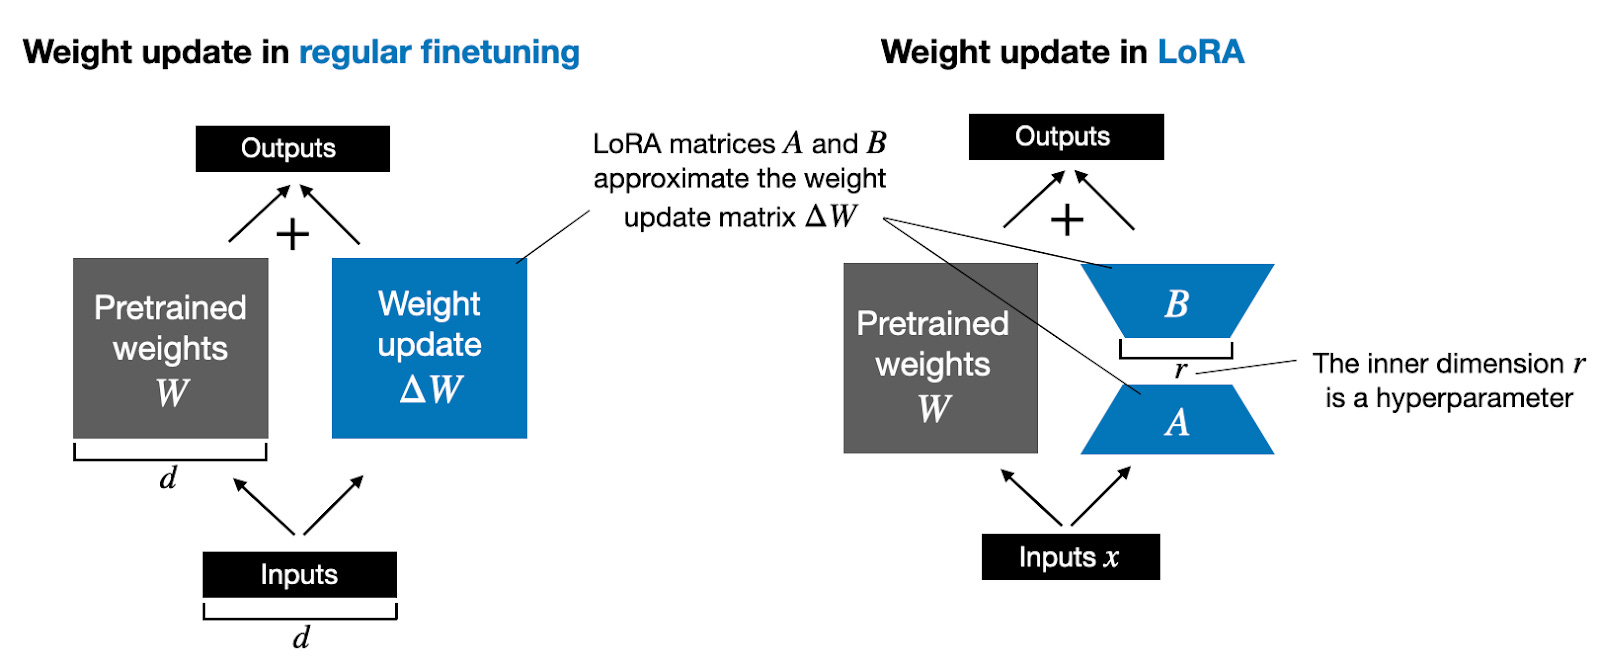

First, we will define the configuration with all the parameters required to define our LoRA adapters.

In [ ]:
#Lora Hyperparameter
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["fc1", "fc2","Wqkv", "out_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

Second, we will define the training hyperparameters.

In [ ]:
#Training hyperparamters
training_arguments = TrainingArguments(
        output_dir="output",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=30,
        max_steps=-1,
        num_train_epochs=2,
        report_to="none"
    )
trainer = Trainer(
    model=model,
    train_dataset=tokenized_training_data["input_ids"],
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

Finally, we will call the train method to perform the finetuning. Remember, that we are only training with 1% of the data. Better results should be expected using the whole dataset.

In [ ]:
#Training
trainer.train()
trainer.model.save_pretrained(new_model)
model.config.use_cache = True
model.eval()

**Exercise 4:** Repeat the same prompts you did before. How did the answers change after the finetuning?

You can try other prompts to understand better the capabilities of the model.

In [ ]:
# TODO


## Prompting and LLM limitations

As mentioned, our model is not too good, as we trained only on a few thousand examples. Let's load a model fully trained to test how LLM can really work.

For these experiments we will use the same model finetuned on Orca. This dataset containes 2.91 million instructions, allowing the model to learn much better how to follow instructions.

In [ ]:
model_name = "Open-Orca/oo-phi-1_5"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map={"": 0},
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)


**Exercise 5:** Repeat the same prompts. How are the answers?

In [ ]:
# TODO


### Prompt Engineering

Prompt engineering is all about how to design your prompts so that the response is what you were indeed hoping to see.

The idea of using "unfancy" prompts is to minimize the noise in your prompt to reduce the possibility of the LLM misinterpreting the intent of the prompt. Below are a few guidelines on how to engineer "unfancy" prompts.

In this section, you'll cover the following best practices when engineering prompts:

* Be concise
* Be specific, and well-defined
* Ask one task at a time
* Improve response quality by including examples
* Turn generative tasks to classification tasks to improve safety

**Exercise 6:** Given the tips above, write a prompt to perform sentiment analysis.  What's the sentiment of the sentence

```
"I loved the new YouTube video you made!"
```



In [ ]:
# TODO
prompt = 
                                phi_stream(...)

Asking the model to do a task without any additional information is called **Zero-shot prompting.** While it can work in some case, providing some context is always helpful.

**Zero-shot prompting** consists in providing some examples of the before the actual we want to solve. This way, the model can figure out better what it needs to do.

An example of few-shot learning could be:

```
Decide the sentiment of the following sentences:
This is awesome! // Negative
This is bad! // Positive
Wow that movie was rad! // Positive
What a horrible show! //
```



Let's play a bit with this idea. Run the following example . Is the answer by the model correct?


In [ ]:
phi_stream("A juggler can juggle 16 balls. Half of them are blue and half of them are red. How many balls can she juggle?")

**Exercise 7:** Think about some examples of similar tasks and adds them to your prompt. Can you obtain a correct answer?

In [ ]:
# TODO
prompt =
                                                        phi_stream(...)

LLMs are quite powerful and can solve a huge variety of complex tasks. But, are they enough?

**Exercise 8:** Ask the model a silly question, such as when did the first elephant landed on the moon. Is the answer factually true?

In [ ]:
# TODO
